In [99]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [100]:
T = 0.01
s = ctl.TransferFunction.s

In [101]:
G = 1/(s**2 + 2*s)
C = (17.446*s**2 + 97.59*s + 66.90)/(s**2 + 20*s)


G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([17.446, 97.59 , 66.9  ]), array([ 1.   , 22.   , 57.446, 97.59 , 66.9  ]))

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [102]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([4.96683267e-05, 4.93383068e-05]), array([ 1.        , -1.98019867,  0.98019867]), 0.01)

In [103]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([ 16.30511136, -31.71695909,  15.41792955]), array([ 1.        , -1.81818182,  0.81818182]), 0.01)

In [104]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 0.00080985, -0.00077086, -0.00079908,  0.00076069]), array([ 1.        , -3.79757064,  5.39797085, -3.40314104,  0.80274143]), 0.01)

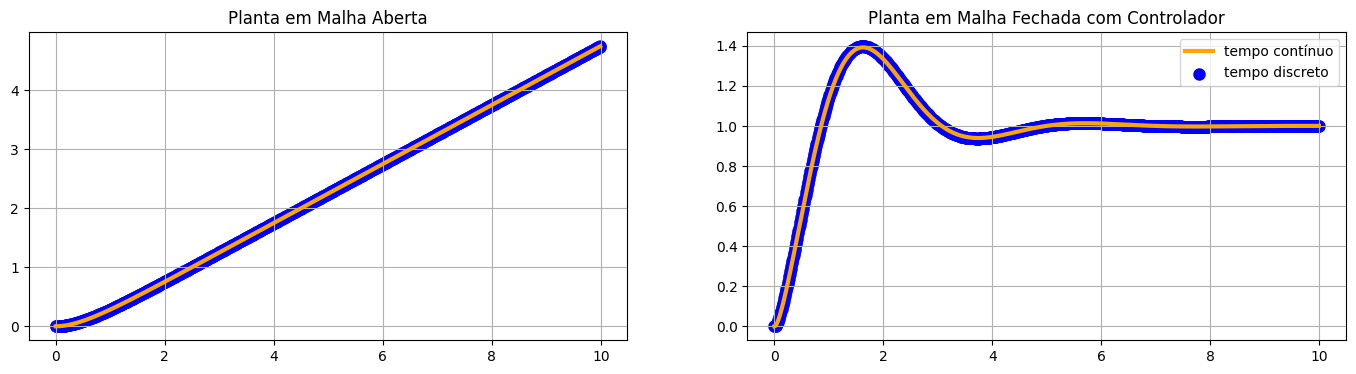

In [105]:
tData = np.arange(0, 10, T)
plt.figure(figsize=(17, 4))

plt.subplot(1, 2, 1)
time, continuous = ctl.step_response(G, T=tData)
time, digital    = ctl.step_response(G_z, T=tData)
plt.scatter(time, continuous, color='blue', linewidth=3, label='tempo discreto')
plt.plot(time, digital, color='orange', linewidth=3, label='tempo contínuo')
plt.title('Planta em Malha Aberta')
plt.grid()

plt.subplot(1, 2, 2)
time, continuous = ctl.step_response(G_feedback, T=tData)
time, digital    = ctl.step_response(G_z_feedback, T=tData)
plt.plot(time, continuous, color='orange', linewidth=3, label='tempo contínuo')
plt.scatter(time, digital, color='blue', linewidth=3, label='tempo discreto')
plt.title('Planta em Malha Fechada com Controlador')
plt.legend()
plt.grid()

# COMPARANDO A RESPOSTA DO CONTROLADOR

- Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada

In [106]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

print(num)
print(den)

[ 16.30511136 -31.71695909  15.41792955]
[ 1.         -1.81818182  0.81818182]


- Printando a saída de forma a ser entendida por uma máquina de baixo nível

In [107]:
out = ''

for i in range(0, len(num)):
    out += f'{num[i]}*X_n{i} + '

for i in range(1, len(den)):
    out += f'+ {-1*den[i]}*Y_n{i}'

out = out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')
print(out + ';')

16.305111363636364*X_n -31.71695909090909*X_n1 + 15.417929545454545*X_n2 + 1.8181818181818181*Y_n1-0.8181818181818181*Y_n2;


- Resposta do controlador em feedback

In [108]:
Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

def computeController(inputValue, setpoint):
    global Y_n1, Y_n2, Y_n3
    global X_n1, X_n2, X_n3

    X_n = setpoint - inputValue
    Y_n = eval(out)

    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

- Comparando os dados contínuo e digital de forma gráfica através de um step

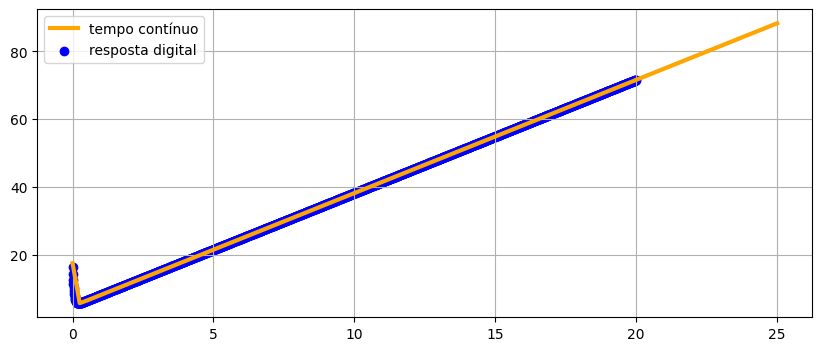

In [109]:
plt.figure(figsize=(10, 4))

time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 20, T)
response = [computeController(1, 2) for i in time] # degrau (erro 1 é a entrada)
plt.scatter(time, response, color='blue', label='resposta digital')

plt.legend()
plt.grid()

# TESTANDO A RESPOSTA
- Se o erro é positivo, o controlador atua aumentando a saída do sistema

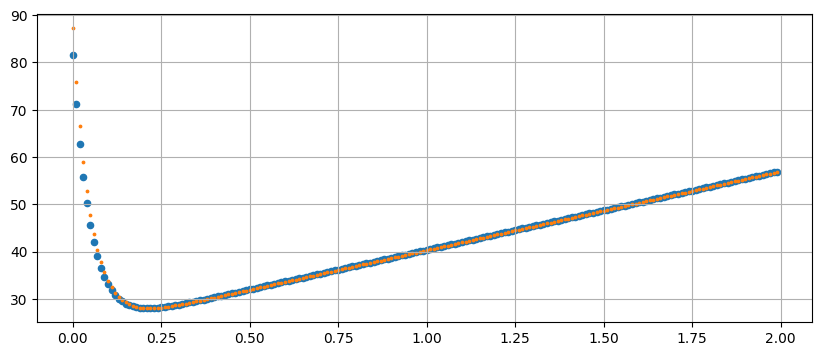

In [110]:
plt.figure(figsize=(10, 4))

inputValue = 5
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)
plt.grid()

- Se o erro é negativo, o controlador atua diminuindo a saída do sistema

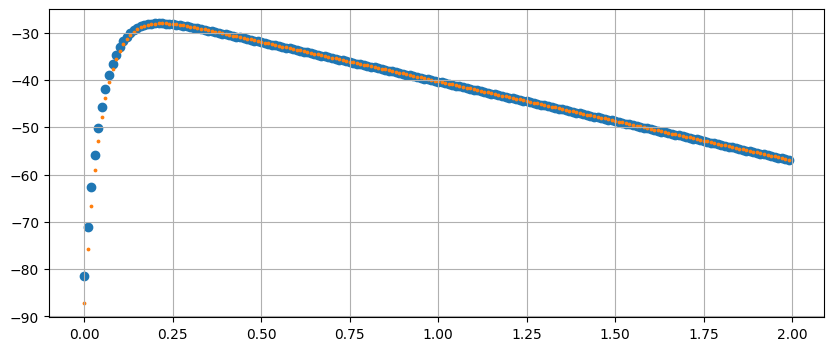

In [111]:
plt.figure(figsize=(10, 4))

inputValue = 15
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)
plt.grid()

- Se o erro é zero, o não atua e mantém a saída fixa

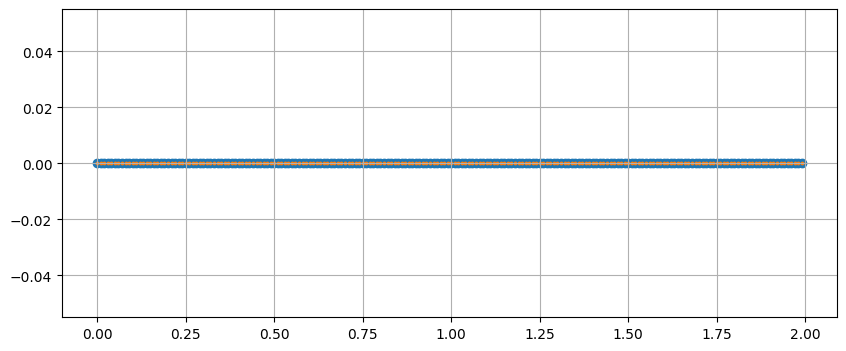

In [112]:
plt.figure(figsize=(10, 4))

inputValue = 10
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = np.arange(0, 2, T)
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)
plt.grid()